# Jóvenes y Adultos en situación de Riesgo Educativo entre 2010 y 2021
## Un estudio comparado entre regiones a partir de la Encuesta Permanente de Hogares

El concepto de Nivel Educativo de Riesgo (NRE), tal como fue construido por las investigadoras María Teresa Sirvent y Sandra Llosa, es de doble dimensión. Por un lado, una cualitativa, relacionada con “la noción de alfabetismo que hace referencia a la compleja red de conocimientos que un ciudadano necesita para analizar crítica y autónomamente los hechos de su entorno barrial, municipal, nacional e internacional.” (Sirvent & Llosa, 1998, p.80). Por otro lado, en una dimesión cuantitativa, el NRE es un indicador concreto: “la población de 15 años y más que asistió a la escuela pero ya no asiste más” (Sirvent & Llosa, 1998, p.79). Así definido, éste indicador permite definir un umbral a partir del cual una persona se puede encontrar en situación de riesgo educativo.

El objetivo principal de este trabajo es estimar qué porcentaje de la población se encuentra hoy en una situación de riesgo educativo según el NRE. A falta de un censo nacional (el último se realizó en 2011 y el próximo se hará en 2022), la fuente que se tomará para realizar esta estimación será la Encuesta Permanente de Hogares del Indec, que releva entre los encuestados si asisten y asistieron a algún establecimiento educativo junto con el máximo nivel escolar alcanzado. Esto permitiría distinguir, en una muestra que se supone representativa, porcentajes de población que se encuentren por debajo de la línea del NRE.

En este notebook se utilizan datos de la Encuesta Permanente de Hogares del INDEC de los último 11 años para realizar una breve caracterización de esa población entre los años 2010 y 2021. Las bases de datos se pueden descargar de [https://www.indec.gob.ar/indec/web/Institucional-Indec-BasesDeDatos](la página del INDEC). Acá utilizo los txt (CSV) que se proveen para el período 2016-2021 y los dta (STATA) para 2010-2015.

### Importar archivos y adecuar formatos
Entre el 2015 y el 2016, las bases de datos de la EPH sufrieron varias modificaciones de formato, por lo cual luego de importar algunas columnas de cada base de datos, efectúo algunas modificaciones para adecuar los formatos de todo el período.

In [1]:
import pandas as pd
from os import listdir
from os.path import isfile, join

In [2]:
statapath = 'EPH\\stata'
textpath = 'EPH\\text'
statadir = listdir(statapath)
textdir = listdir(textpath)
statafiles = [f for f in statadir if isfile(join(statapath, f))]
textfiles = [f for f in textdir if isfile(join(textpath, f))]

In [3]:
# los datos que utilizo corresponden al segundo trimestre de cada año
t2 = [file for file in statafiles] + [file for file in textfiles]

In [4]:
# levantar los datos en dataframes
txtcols = ['CODUSU','ANO4','TRIMESTRE','NRO_HOGAR','COMPONENTE','H15','REGION',
           'MAS_500','AGLOMERADO','PONDERA','CH03' ,'CH04','CH05','CH06','CH07',
           'CH08','CH09','CH10','CH11','CH12','CH13','CH14','NIVEL_ED']
statacols = ['CODUSU', 'ano4', 'trimestre', 'nro_hogar', 'componente', 'h15', 
             'region', 'mas_500', 'aglomerado', 'pondera', 'ch03', 'ch04', 
             'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 
             'ch14', 'nivel_ed']

epht2 = [pd.read_stata(join(statapath, file), columns=statacols) for file in t2[:6]] + [pd.read_csv(join(textpath, file), sep=";", usecols=txtcols) for file in t2[6:]]

#### Adecuar formatos 
De 2015 a 2016 se modificó el tipo de datos con el que se representan algunas variables medidas por la EPH. Principalmente, a todas las preguntas que admiten una respuesta categórica se les dió un código numérico que ahora es el que figura como respuesta de cada entrevistado. Además, los nombres de las columnas pasaron de estar indicados en minúsculas a mayúsculas. Para poder comparar más fácilmente, compatibilizo todos esos formatos.

In [5]:
# renombro columnas (todas a minúsculas) y las regiones (todas string con nombres de cada región)
def lowercasecolumns(datalist):
    for df in datalist:
        df.rename(str.lower, axis='columns', inplace=True)

def lowercaseCODUSU(datalist):
    for df in datalist:
        df.rename(columns={'CODUSU': 'codusu'}, inplace=True)

def int_to_str(datalist, column, d):
    """Dada una lista de dataframes, modifica los valores de una columna.
    d: dict con los valores a modificar (los keys son los valores a reemplazar)
    datalist: list de dataframes
    column: string con la columna"""
    for df in datalist:
        df[column].replace(d, inplace=True)

regiones = {1: 'Gran Buenos Aires', 40: 'NOA', 41: 'NEA', 42: 'Cuyo', 43: 'Pampeana', 44: 'Patagónica'}
parentesco = {1: 'Jefe', 2: 'Cónyuge/Pareja', 3: 'Hijo/Hijastro', 4:'Yerno/Nuera', 5: 'Nieto', 6: 'Madre/Padre',
              7: 'Suegro', 8: 'Hermano', 9: 'Otros familiares', 10: 'No familiares'}
sexo = {1: 'Varón', 2: 'Mujer'}
civil = {1: 'Unido', 2: 'Casado', 3: 'Separado o divorciado', 4: 'Viudo', 5: 'Soltero', 9: 'Ns./Nr.'}
cobertura = {1: 'Obra social (incluye PAMI)', 2: 'Mutual/Prepaga/Servicio de emergencia', 
             3: 'Planes y seguros públicos', 4: 'No paga ni le descuentan', 9: 'Ns./Nr.', 
             12: 'Obra social y mutual/prepaga/servicio de emergencia', 13: 'Obra social y planes y seguros públicos',
             23: 'Mutual/prepaga/servicio de emergencia/planes y seguros públicos',
             123: 'Obra social, mutual/prepaga/servicio de emergencia y planes y seguros públicos'}
alfabet = {1: 'Sí', 2: 'No', 3: 'Menor de 2 años'}
asistencia = {1: 'Sí, asiste', 2: 'No asiste, pero asistió', 3: 'Nunca asistió'}
establecimiento = {1: 'Público', 2: 'Privado', 3: 'Ns./Nr.'}
nivel = {1: 'Jardín', 2: 'Primario', 3: 'EGB', 4: 'Secundario', 5: 'Polimodal', 6: 'Terciario', 7: 'Universitario',
        8: 'Posgrado universitario', 9: 'Educación especial (discapacitado)'}
final = {1: 'Sí', 2: 'No', 3: 'Ns./Nr.'}
ultimo = {0: 'Ninguno', 1: 'Primero', 2: 'Segundo', 3: 'Tercero', 4: 'Cuarto', 5: 'Quinto', 6: 'Sexto', 7: 'Séptimo',
          8: 'Octavo', 9: 'Noveno', 98: 'Educación especial', 99: 'Ns./Nr.'}
nivel_ed = {1: 'Primaria Incompleta (incluye educación especial)', 2: 'Primaria Completa', 3: 'Secundaria Incompleta',
            4: 'Secundaria Completa', 5: 'Superior Universitaria Incompleta', 6: 'Superior Universitaria Completa',
            7: 'Sin instrucción', 9: 'Ns./Nr.'}

lowercasecolumns(epht2)
lowercaseCODUSU(epht2)
int_to_str(epht2, 'region', regiones)
int_to_str(epht2, 'ch03', parentesco)
int_to_str(epht2, 'ch04', sexo)
int_to_str(epht2, 'ch07', civil)
int_to_str(epht2, 'ch08', cobertura)
int_to_str(epht2, 'ch09', alfabet)
int_to_str(epht2, 'ch10', asistencia)
int_to_str(epht2, 'ch11', establecimiento)
int_to_str(epht2, 'ch12', nivel)
int_to_str(epht2, 'ch13', final)
int_to_str(epht2, 'ch14', ultimo)
int_to_str(epht2, 'nivel_ed', nivel_ed)

## Población de la EPH

En lo que sigue se calcula las siguientes poblaciones discriminadas por región:
 - La población total que representa la EPH.
 - La población de 15 y más años (y cuántos son como porcentaje de la población total).

In [6]:
# poblacion por región muestreada
pob = pd.DataFrame([df.groupby('region')['pondera'].sum() for df in epht2], index=range(2010,2022))
pob.rename_axis('año', inplace=True)
pob['Total'] = pob.sum(axis=1)
pob

region,Cuyo,Gran Buenos Aires,NEA,NOA,Pampeana,Patagónica,Total
año,,,,,,,
2010,1571221.0,13034624.0,1284095.0,2410805.0,5733959.0,825574.0,24860278.0
2011,1589060.0,13132349.0,1304024.0,2445558.0,5783157.0,837685.0,25091833.0
2012,1606555.0,13229834.0,1323735.0,2480319.0,5831948.0,849611.0,25322002.0
2013,1623847.0,13326511.0,1343360.0,2514496.0,5880509.0,861549.0,25550272.0
2014,1785933.0,13722819.0,1383895.0,2612202.0,6109153.0,979563.0,26593565.0
2015,1809387.0,13829906.0,1400134.0,2644256.0,6164586.0,999872.0,26848141.0
2016,1650337.0,14695899.0,1343714.0,2605216.0,5913500.0,992064.0,27200730.0
2017,1665397.0,14863081.0,1356730.0,2631827.0,5958942.0,1010472.0,27486449.0
2018,1680153.0,15028359.0,1369129.0,2658667.0,6004125.0,1028030.0,27768463.0


In [7]:
# variación de la población
varpob = (pob.Total[2021] - pob.Total[2010])/pob.Total[2010] * 100
varpob

16.138842051565153

In [8]:
# población de 15 y más años
plus15 = pd.DataFrame([df.query('ch06>=15').groupby('region')['pondera'].sum() for df in epht2], index=range(2010,2022))
plus15.rename_axis('año', inplace=True)
plus15['Total'] = plus15.sum(axis=1)
plus15

region,Cuyo,Gran Buenos Aires,NEA,NOA,Pampeana,Patagónica,Total
año,,,,,,,
2010,1161705.0,10035064.0,928245.0,1748644.0,4454480.0,610795.0,18938933.0
2011,1178452.0,10077637.0,948621.0,1784509.0,4506612.0,622529.0,19118360.0
2012,1194230.0,10163972.0,967759.0,1818564.0,4556460.0,633672.0,19334657.0
2013,1215201.0,10262950.0,987621.0,1860584.0,4614940.0,645359.0,19586655.0
2014,1338327.0,10335058.0,1017948.0,1922270.0,4718391.0,723178.0,20055172.0
2015,1364968.0,10410869.0,1043514.0,1966100.0,4775897.0,743227.0,20304575.0
2016,1280863.0,11462908.0,1046644.0,1956892.0,4695949.0,750007.0,21193263.0
2017,1295049.0,11506937.0,1062003.0,1997238.0,4719960.0,770863.0,21352050.0
2018,1284631.0,11727822.0,1065434.0,2030635.0,4739693.0,802563.0,21650778.0


In [9]:
# crecimiento de esta población
varplus15 = (plus15.Total[2021] - plus15.Total[2010])/plus15.Total[2010] * 100
varplus15

17.19685053006946

In [10]:
# como porcentaje de la población de la EPH
plus15/pob*100

region,Cuyo,Gran Buenos Aires,NEA,NOA,Pampeana,Patagónica,Total
año,,,,,,,
2010,73.936448,76.987752,72.287876,72.533614,77.685941,73.984282,76.181501
2011,74.160321,76.739028,72.745670,72.969400,77.926503,74.315405,76.193557
2012,74.334834,76.826149,73.108213,73.319762,78.129297,74.583780,76.355167
2013,74.834698,77.011530,73.518714,73.994311,78.478581,74.906825,76.659282
2014,74.937134,75.312937,73.556737,73.588107,77.234782,73.826594,75.413627
2015,75.438146,75.277945,74.529581,74.353618,77.473118,74.332215,75.627489
2016,77.612209,78.000727,77.891873,75.114386,79.410654,75.600667,77.914317
2017,77.762179,77.419594,78.276665,75.887891,79.208020,76.287418,77.682097
2018,76.459168,78.037941,77.818379,76.377937,78.940612,78.068052,77.968946


## Población en Situación de Riesgo Educativo
La población en situación de riesgo educativo es aquella que cumple con:
- [x] Tener 15 o más años.
- [x] Haber asistido al colegio y dejado.
- [x] No haber terminado el secundario.

Para obtener a esta población, hago un query tomando a los mayores de 15, que declaren haber asistido a la escuela pero ya no hacerlo, y cuyo nivel educativo sea "Secundaria Incompleta", "Primaria Completa" o "Primaria Incompleta".

In [11]:
sre_cond = 'ch06 >= 15 & ch10 == "No asiste, pero asistió"'
nivel_cond = 'nivel_ed == "Secundaria Incompleta" | nivel_ed == "Primaria Incompleta (incluye educación especial)" | nivel_ed == "Primaria Completa"'
sreregion = [df.query(sre_cond).query(nivel_cond).groupby('region')['pondera'].sum() for df in epht2]
dfsre = pd.DataFrame(sreregion, index=range(2010,2022))
dfsre.rename_axis('año', inplace=True)
dfsre

region,Cuyo,Gran Buenos Aires,NEA,NOA,Pampeana,Patagónica
año,,,,,,
2010,465805.0,4283164.0,375343.0,677588.0,1782707.0,248404.0
2011,477558.0,4240168.0,367549.0,707057.0,1786924.0,249658.0
2012,493191.0,4206813.0,366722.0,669491.0,1754238.0,244488.0
2013,493101.0,4085519.0,381365.0,667969.0,1685216.0,248427.0
2014,541729.0,4022579.0,364023.0,719583.0,1779031.0,286581.0
2015,526473.0,4177662.0,366737.0,700301.0,1766397.0,299206.0
2016,488431.0,4577971.0,351811.0,650231.0,1747156.0,282809.0
2017,485799.0,4386771.0,340424.0,685362.0,1762140.0,283159.0
2018,480557.0,4316021.0,336138.0,700898.0,1685287.0,279397.0


In [12]:
# grafico de esta población
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.style.use('ggplot')
plt.rcParams['legend.title_fontsize'] = 14

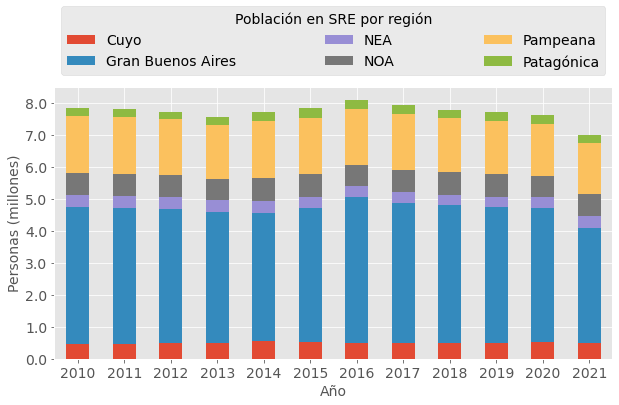

In [13]:
# grafico
ax = dfsre.plot.bar(figsize=(10,5),
                    fontsize=14,
                    stacked=True,
                    rot = 0)
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
# plt.ticklabel_format(style='plain', axis='y')
plt.xlabel(xlabel='Año', fontsize=14)
plt.ylabel(ylabel='Personas (millones)', fontsize=14)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol=3, mode='expand', 
           title='Población en SRE por región',
           fontsize=14)

In [14]:
# calculo total de la población en SRE
dfsre['Total'] = dfsre.sum(axis=1)

In [15]:
dfsre

region,Cuyo,Gran Buenos Aires,NEA,NOA,Pampeana,Patagónica,Total
año,,,,,,,
2010,465805.0,4283164.0,375343.0,677588.0,1782707.0,248404.0,7833011.0
2011,477558.0,4240168.0,367549.0,707057.0,1786924.0,249658.0,7828914.0
2012,493191.0,4206813.0,366722.0,669491.0,1754238.0,244488.0,7734943.0
2013,493101.0,4085519.0,381365.0,667969.0,1685216.0,248427.0,7561597.0
2014,541729.0,4022579.0,364023.0,719583.0,1779031.0,286581.0,7713526.0
2015,526473.0,4177662.0,366737.0,700301.0,1766397.0,299206.0,7836776.0
2016,488431.0,4577971.0,351811.0,650231.0,1747156.0,282809.0,8098409.0
2017,485799.0,4386771.0,340424.0,685362.0,1762140.0,283159.0,7943655.0
2018,480557.0,4316021.0,336138.0,700898.0,1685287.0,279397.0,7798298.0


### La población en SRE en números
En esta sección calculo:
- [x] La población en SRE como porcentaje de la población total de la EPH.
- [x] La población en SRE como porcentaje de la población de 15 y más años.
- [x] La variación de la población en SRE entre 2010 y 2021

In [16]:
# como porcentaje del total de la EPH
dfsre/pob*100

region,Cuyo,Gran Buenos Aires,NEA,NOA,Pampeana,Patagónica,Total
año,,,,,,,
2010,29.646052,32.859897,29.230158,28.106296,31.090334,30.088641,31.508139
2011,30.052861,32.287963,28.185754,28.911888,30.898763,29.803327,31.201045
2012,30.698669,31.797927,27.703581,26.992133,30.079795,28.776464,30.546333
2013,30.366223,30.657079,28.388891,26.564727,28.657655,28.834924,29.594977
2014,30.333109,29.313066,26.304236,27.546989,29.120747,29.256005,29.005235
2015,29.096760,30.207450,26.192993,26.483858,28.653944,29.924430,29.189269
2016,29.595834,31.151350,26.181985,24.958813,29.545210,28.507133,29.772763
2017,29.170162,29.514547,25.091507,26.041301,29.571357,28.022449,28.900259
2018,28.601979,28.719177,24.551229,26.362760,28.068819,27.177903,28.083290


In [17]:
# como porcentaje de la población de 15 y más años
dfsre15 = dfsre/plus15*100
dfsre15

region,Cuyo,Gran Buenos Aires,NEA,NOA,Pampeana,Patagónica,Total
año,,,,,,,
2010,40.096668,42.681980,40.435769,38.749339,40.020541,40.668964,41.359305
2011,40.524179,42.075022,38.745611,39.621935,39.651161,40.103835,40.949715
2012,41.297824,41.389459,37.893938,36.814267,38.500020,38.582737,40.005587
2013,40.577732,39.808427,38.614509,35.901040,36.516531,38.494388,38.605862
2014,40.478074,38.921688,35.760471,37.434023,37.704188,39.628003,38.461530
2015,38.570355,40.127889,35.144425,35.618788,36.985659,40.257687,38.596109
2016,38.132962,39.937257,33.613244,33.227741,37.205600,37.707515,38.212186
2017,37.512017,38.122838,32.054900,34.315490,37.333791,36.732727,37.203243
2018,37.408174,36.801556,31.549397,34.516198,35.556881,34.813093,36.018558


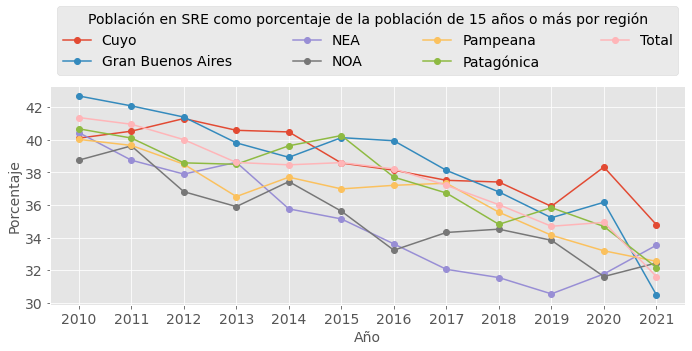

In [18]:
# grafico esto último
dfsre15.rename(columns={'total': 'Total'}, inplace=True)
ax = dfsre15.plot.line(figsize=(10,5),
              fontsize=14,
              style='-o')
ax.set_xticks(dfsre15.index)
plt.xlabel(xlabel='Año', fontsize=14)
plt.ylabel(ylabel='Porcentaje', fontsize=14)
plt.legend(title='Población en SRE como porcentaje de la población de 15 años o más por región', 
           fontsize=14, ncol=4, bbox_to_anchor=(0., 1.02, 1., .102), mode='expand')
plt.tight_layout()

In [19]:
# variación porcentual de la población en SRE 
var = dfsre.Total[2021] - dfsre.Total[2010]
varp = (var) * 100 / dfsre.Total[2010]
print(f'Jóvenes y adultos en SRE en 2010: {int(dfsre.Total[2010])}.')
print(f'Jóvenes y adultos en SRE en 2021: {int(dfsre.Total[2021])}.')
print(f'Variación de esta población: {var:n}.')
print(f'Variación de esta población en porcentaje: {varp:.2f}%.')

Jóvenes y adultos en SRE en 2010: 7833011.
Jóvenes y adultos en SRE en 2021: 7016722.
Variación de esta población: -816289.
Variación de esta población en porcentaje: -10.42%.


In [20]:
# variacion de la brecha entre regiones
brecha10 = dfsre15['Gran Buenos Aires'][2010] - dfsre15.NOA[2010]
brecha21 = dfsre15.Cuyo[2021] - dfsre15['Gran Buenos Aires'][2021]
varbrecha = brecha21-brecha10
print(f'Brecha en 2010: {brecha10:.2f}pp.')
print(f'Brecha en 2021: {brecha21:.2f}pp.')
print(f'Variación de la brecha: {varbrecha:.2f}pp.')

Brecha en 2010: 3.93pp.
Brecha en 2021: 4.30pp.
Variación de la brecha: 0.37pp.


In [21]:
#variaciones por región
dfsre15.loc[2021,:] - dfsre15.loc[2010,:]

region
Cuyo                 -5.306953
Gran Buenos Aires   -12.191934
NEA                  -6.902011
NOA                  -6.304950
Pampeana             -7.475647
Patagónica           -8.506608
Total                -9.746515
dtype: float64

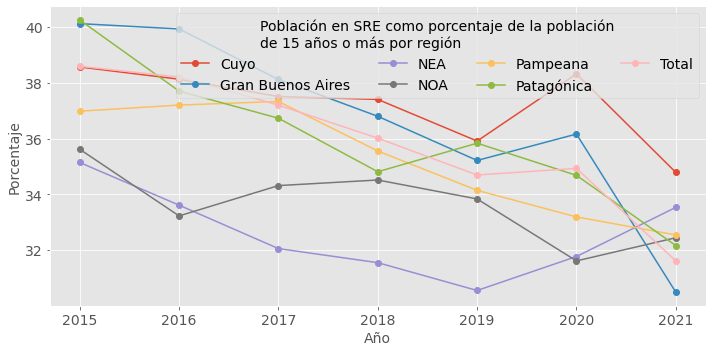

In [22]:
# gráfico 2016-2021
ax2 = dfsre15.loc[2015:2021,:].plot.line(figsize=(10,5),
              fontsize=14,
              style='-o')
# ax2.set_xticks(dfsre15.index)
plt.xlabel(xlabel='Año', fontsize=14)
plt.ylabel(ylabel='Porcentaje', fontsize=14)
plt.legend(title='Población en SRE como porcentaje de la población\nde 15 años o más por región', 
           fontsize=14, 
           ncol=4,
           loc='upper right')
plt.tight_layout()

In [23]:
# variaciones por region en 2016-2021 y 2015-2010
#variaciones por región
dfsre15.loc[2015,:] - dfsre15.loc[2010,:], dfsre15.loc[2021,:] - dfsre15.loc[2016,:]

(region
 Cuyo                -1.526313
 Gran Buenos Aires   -2.554090
 NEA                 -5.291343
 NOA                 -3.130551
 Pampeana            -3.034882
 Patagónica          -0.411277
 Total               -2.763195
 dtype: float64,
 region
 Cuyo                -3.343246
 Gran Buenos Aires   -9.447211
 NEA                 -0.079486
 NOA                 -0.783351
 Pampeana            -4.660706
 Patagónica          -5.545158
 Total               -6.599396
 dtype: float64)

### Composición por sexo de la población en SRE

In [24]:
sre = [df.query(sre_cond).query(nivel_cond) for df in epht2]

In [25]:
porSexo = [pd.crosstab(index=df['ch04'], columns=df['region'], values=df['pondera'], 
                    aggfunc = sum, margins=True, normalize='columns')*100 for df in sre]

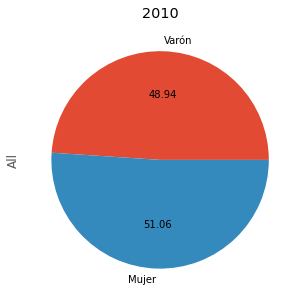

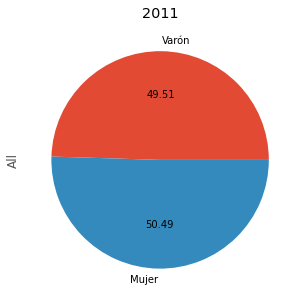

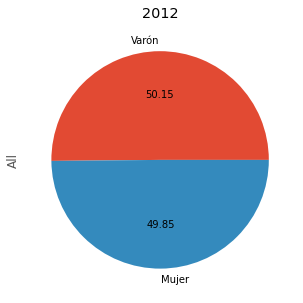

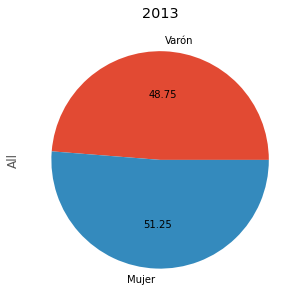

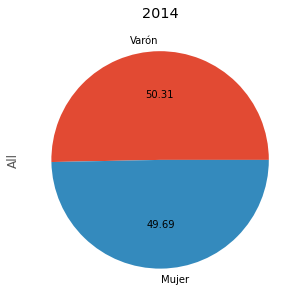

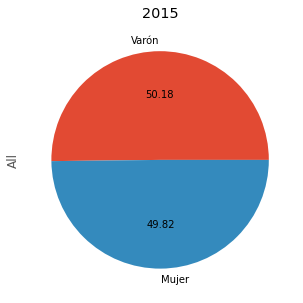

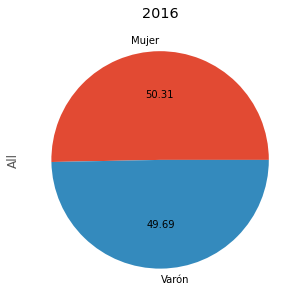

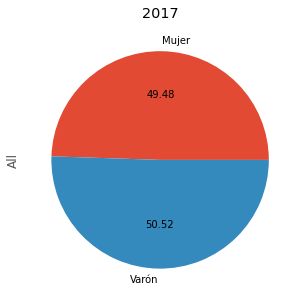

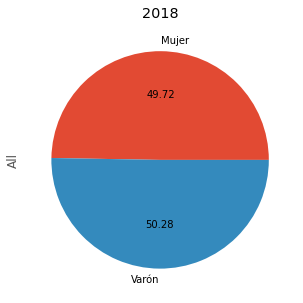

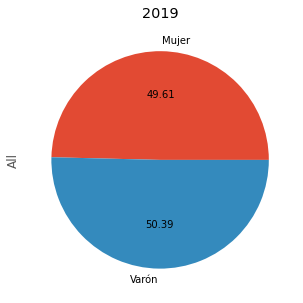

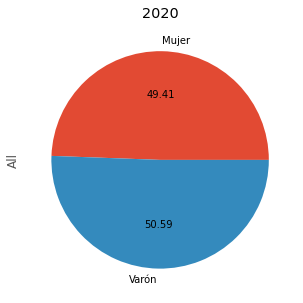

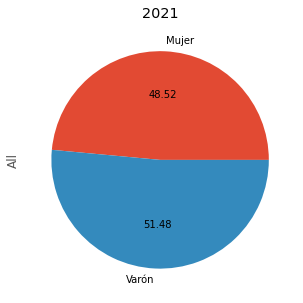

In [26]:
# grafico composición total
año = 2010
for ct in porSexo:
    ct.All.plot.pie(title=f'{año}', figsize=(10,5), labels=ct.index, autopct='%.2f')
    plt.show()
    año+=1

In [27]:
# datos completos
porSexo

[region  Gran Buenos Aires        NOA        NEA       Cuyo   Pampeana  \
 ch04                                                                    
 Varón           48.887365  50.982013  47.696374  47.885489  48.574555   
 Mujer           51.112635  49.017987  52.303626  52.114511  51.425445   
 
 region  Patagónica        All  
 ch04                           
 Varón    50.913431  48.944971  
 Mujer    49.086569  51.055029  ,
 region  Gran Buenos Aires        NOA        NEA       Cuyo   Pampeana  \
 ch04                                                                    
 Varón           49.391392  50.573858  48.968165  47.803199  49.551296   
 Mujer           50.608608  49.426142  51.031835  52.196801  50.448704   
 
 region  Patagónica        All  
 ch04                           
 Varón    52.223442  49.508246  
 Mujer    47.776558  50.491754  ,
 region  Gran Buenos Aires        NOA        NEA       Cuyo   Pampeana  \
 ch04                                                           

### Composición por nivel educativo y edad
#### Por nivel educativo

In [28]:
porNivel = [df.groupby('nivel_ed')['pondera'].sum() for df in sre]
dfporNivel = pd.DataFrame(porNivel, index=range(2010,2022))
dfporNivel.drop(columns=['Secundaria Completa', 'Sin instrucción', 'Superior Universitaria Completa', 'Superior Universitaria Incompleta'], inplace=True)
dfporNivel['Total'] = dfporNivel.sum(axis=1)

In [29]:
dfporNivel

nivel_ed,Primaria Completa,Primaria Incompleta (incluye educación especial),Secundaria Incompleta,Total
2010,3882367.0,1340784.0,2609860.0,7833011.0
2011,3910392.0,1226905.0,2691617.0,7828914.0
2012,3983143.0,1198338.0,2553462.0,7734943.0
2013,3746282.0,1127312.0,2688003.0,7561597.0
2014,3843115.0,1074492.0,2795919.0,7713526.0
2015,3880116.0,1127221.0,2829439.0,7836776.0
2016,3953552.0,1246609.0,2898248.0,8098409.0
2017,3781347.0,1206610.0,2955698.0,7943655.0
2018,3633530.0,1158189.0,3006579.0,7798298.0
2019,3553201.0,1172085.0,2995889.0,7721175.0


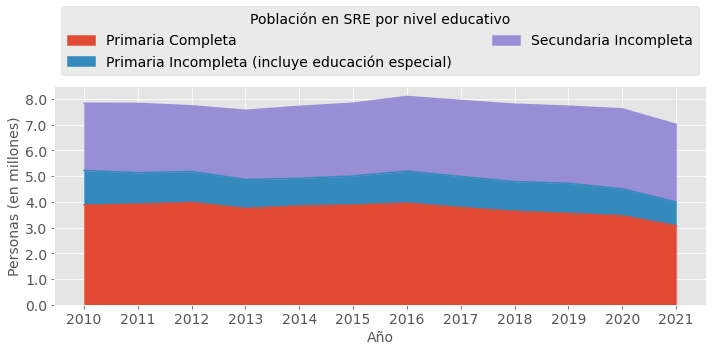

In [30]:
ax3 = dfporNivel.loc[:, dfporNivel.columns != 'Total'].plot.area(figsize=(10,5), fontsize=14,)
ax3.set_xticks(dfporNivel.index)
ax3.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x)/1000000, ',')))
plt.xlabel(xlabel='Año', fontsize=14)
plt.ylabel(ylabel='Personas (en millones)', fontsize=14)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode='expand', 
           title='Población en SRE por nivel educativo', fontsize=14)
plt.tight_layout()

In [31]:
dfporNivelporc = dfporNivel.div(dfporNivel.Total, axis=0)*100
dfporNivelporc

nivel_ed,Primaria Completa,Primaria Incompleta (incluye educación especial),Secundaria Incompleta,Total
2010,49.564171,17.117096,33.318733,100.0
2011,49.948077,15.671458,34.380465,100.0
2012,51.495441,15.492525,33.012034,100.0
2013,49.543529,14.908385,35.548086,100.0
2014,49.823064,13.929972,36.246964,100.0
2015,49.511636,14.383734,36.104630,100.0
2016,48.818873,15.393258,35.787869,100.0
2017,47.602105,15.189607,37.208288,100.0
2018,46.593885,14.851818,38.554297,100.0
2019,46.018916,15.180138,38.800947,100.0


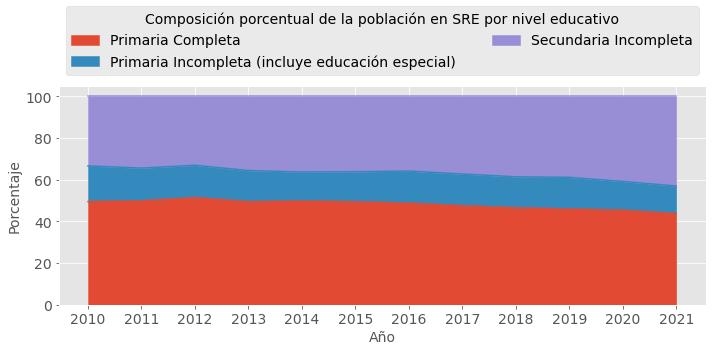

In [32]:
ax4 = dfporNivelporc.loc[:, dfporNivel.columns != 'Total'].plot.area(figsize=(10,5), fontsize=14,)
ax4.set_xticks(dfporNivelporc.index)
ax4.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel(xlabel='Año', fontsize=14)
plt.ylabel(ylabel='Porcentaje', fontsize=14)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), ncol=2, mode='expand', 
           title='Composición porcentual de la población en SRE por nivel educativo', fontsize=14)
plt.tight_layout()

#### Por edad

In [33]:
poredad = [df.groupby('ch06')['pondera'].sum() for df in sre]
dfporedad = pd.DataFrame(poredad, index=range(2010,2022))
dfporedad.drop(columns='Menos de 1 año', inplace=True)
dfporedad.rename(columns={'98 y más años': 98}, inplace=True)

In [34]:
dfporedad.columns

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
             94,  95,  96,  97,  98,  99, 100, 101, 102,  98],
           dtype='int64', name='ch06', length=103)

In [35]:
dfporedad

ch06,1,2,3,4,5,6,7,8,9,10,...,94,95,96,97,98,99,100,101,102,98
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6549.0,4451.0,589.0,3642.0,NaN,NaN,NaN,NaN,NaN,2406.0
2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6265.0,3030.0,5429.0,2077.0,NaN,NaN,NaN,NaN,NaN,1645.0
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11152.0,1706.0,4152.0,1821.0,NaN,NaN,NaN,NaN,NaN,5566.0
2013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2986.0,9081.0,2990.0,1365.0,NaN,NaN,NaN,NaN,NaN,7951.0
2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4240.0,1220.0,1909.0,2314.0,NaN,NaN,NaN,NaN,NaN,2516.0
2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8640.0,5538.0,3132.0,1796.0,NaN,NaN,NaN,NaN,NaN,5394.0
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8393.0,5221.0,4005.0,6958.0,2084.0,NaN,NaN,NaN,NaN,NaN
2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3803.0,2504.0,1972.0,2369.0,2587.0,4614.0,180.0,NaN,NaN,NaN
2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3289.0,2051.0,2810.0,676.0,625.0,737.0,634.0,1848.0,NaN,NaN
2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8498.0,1599.0,2394.0,2548.0,4083.0,325.0,NaN,NaN,2108.0,NaN


In [36]:
# pivoteo el df, pongo los años en columnas y las edades como index, reemplazo los NaN por ceros
table = pd.pivot_table(dfporedad, columns=dfporedad.index)
table.drop(index=list(range(1,15)), inplace=True)
table.fillna(value=0, inplace=True)
table

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ch06,,,,,,,,,,,,
15,29039.0,19566.0,30313.0,27255.0,25753.0,26583.0,26451.0,16214.0,11762.0,8728.0,5103.0,22275.0
16,37074.0,53997.0,50048.0,46297.0,48281.0,42166.0,37457.0,45223.0,23536.0,23569.0,22791.0,9489.0
17,67106.0,63388.0,83972.0,71060.0,64159.0,72798.0,55299.0,52527.0,50077.0,51722.0,36488.0,24003.0
18,113151.0,84273.0,94509.0,88053.0,90724.0,90763.0,110476.0,91520.0,76911.0,70043.0,58699.0,42557.0
19,122687.0,147657.0,112964.0,118216.0,98888.0,110599.0,93264.0,95307.0,70700.0,82106.0,73153.0,66795.0
...,...,...,...,...,...,...,...,...,...,...,...,...
98,2406.0,1645.0,5566.0,7951.0,2516.0,5394.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4614.0,737.0,325.0,349.0,6836.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,634.0,0.0,0.0,0.0


In [37]:
import numpy as np
import math

In [38]:
años = np.arange(2010, 2022)
edadMedia = np.zeros(años.size)
edadSTD = np.zeros(años.size)

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

i = 0

for column in table.columns:
    values = weighted_avg_and_std(table.index, weights=table[column])
    edadMedia[i] = values[0]
    edadSTD[i] = values[1]
    i+=1

In [39]:
edadMedia

array([48.35463451, 48.33095357, 48.61034567, 48.96081013, 48.11064304,
       48.491876  , 49.99034465, 50.21907132, 50.77455093, 50.92624996,
       49.61375224, 50.9231865 ])

In [40]:
edadSTD

array([18.95455223, 18.95460932, 19.07056894, 19.29376385, 18.88079375,
       19.04119903, 19.20463858, 19.2000351 , 19.02212779, 19.14275189,
       18.35693276, 18.62052014])

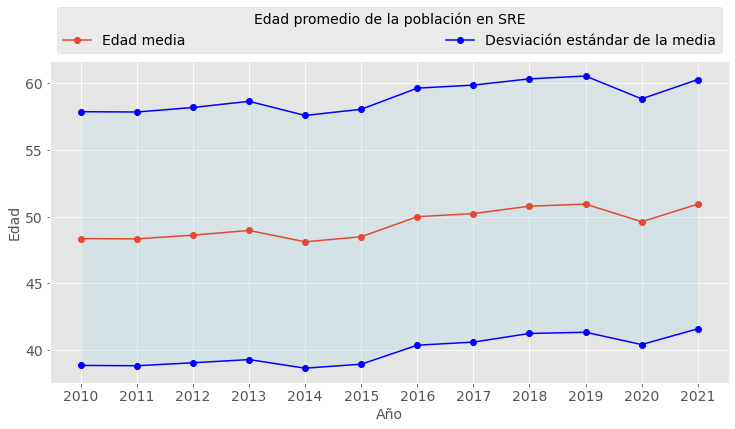

In [41]:
fig, ax5 = plt.subplots(1,1, figsize=(10,5))
ax5.fill_between(años, edadMedia, edadMedia-edadSTD/2, alpha=0.3, color='lightblue', label='Desviación de la media')
ax5.fill_between(años, edadMedia, edadMedia+edadSTD/2, alpha=0.2, color='lightblue')
ax5.plot(años, edadMedia, '-o', label='Edad media')
ax5.plot(años, edadMedia-edadSTD/2, '-o', color='blue')
ax5.plot(años, edadMedia+edadSTD/2, '-o', color='blue')
ax5.set_xticks(años);
plt.tight_layout()
ax5.legend(labels=['Edad media', 'Desviación estándar de la media'], title='Edad promedio de la población en SRE',
         fontsize=14, bbox_to_anchor=(0., 1.09, 1., .102), mode='expand', ncol=2)
ax5.set_xlabel('Año', fontsize=14)
ax5.set_ylabel('Edad', fontsize=14)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

In [104]:
# cruce por edad y nivel
edadynivel = [pd.crosstab(index=df['ch06'], columns=df['nivel_ed'], values=df['pondera'], 
                    aggfunc = sum, margins=True, normalize='index')*100 for df in sre]
for df in edadynivel[:6]:
    df.drop(index='Menos de 1 año', inplace=True)
    df.drop(index=list(range(1,15)), 
            columns=['Secundaria Completa', 'Superior Universitaria Incompleta', 'Superior Universitaria Completa', 'Sin instrucción'],
            inplace=True)

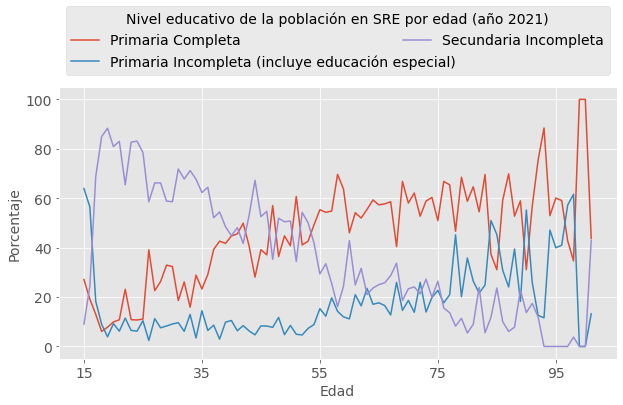

In [102]:
edadynivel[11].plot(figsize=(10,5))
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), mode='expand', ncol=2, fontsize=14,
           title='Nivel educativo de la población en SRE por edad (año 2021)')
plt.xlabel('Edad', fontsize=14)
plt.ylabel('Porcentaje', fontsize=14)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);

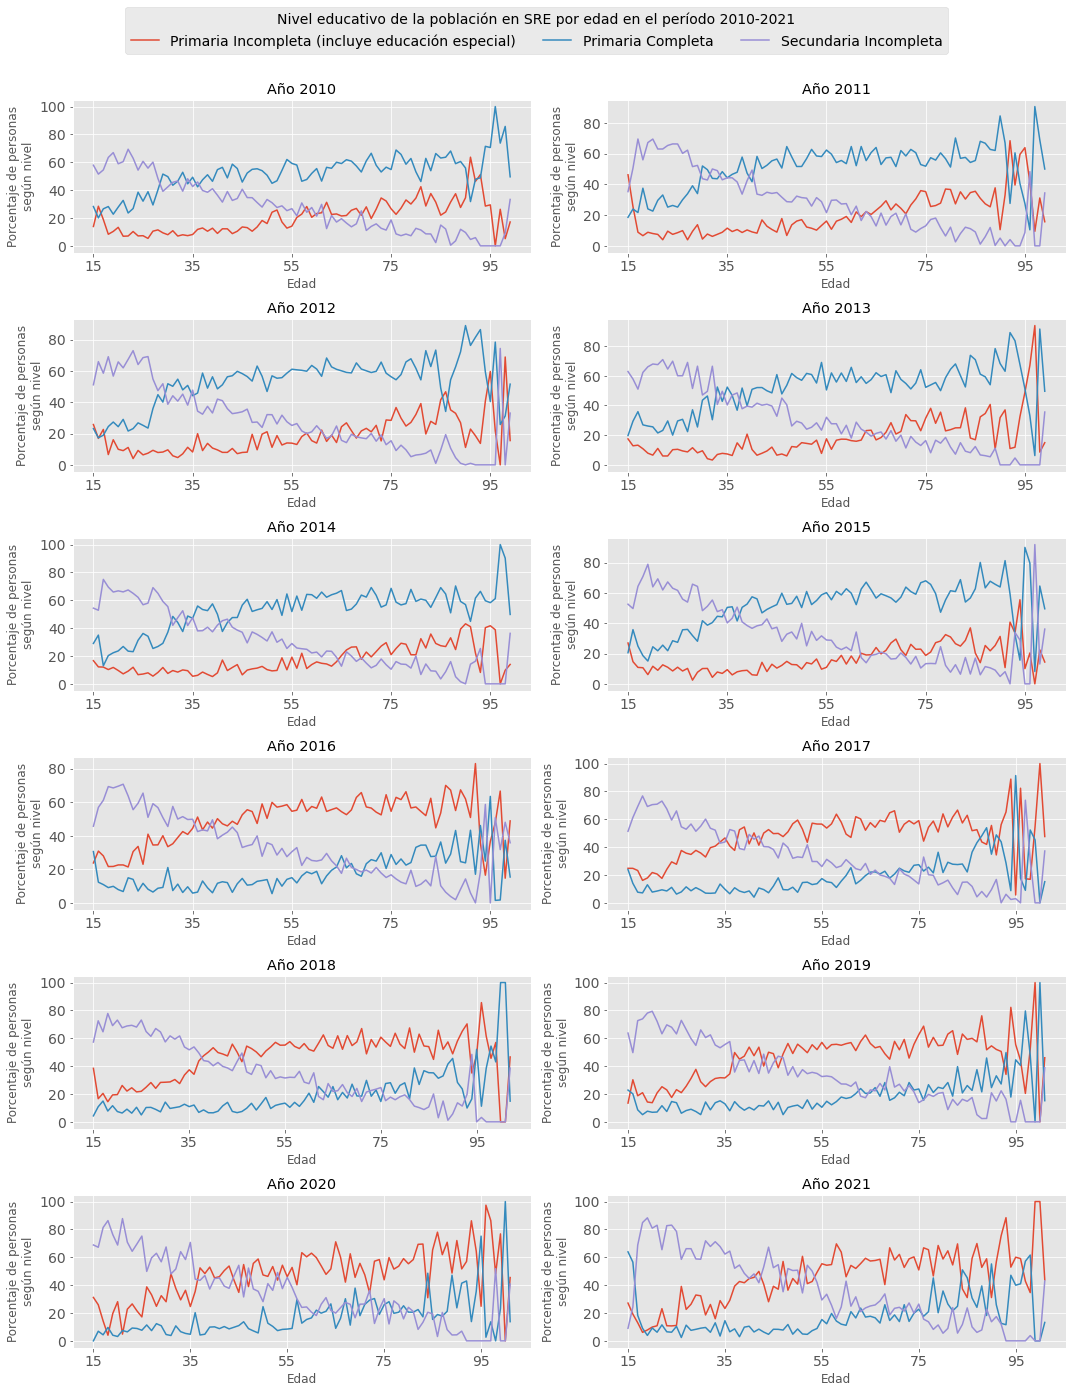

In [128]:
# para cada año
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(15,20))
axes = axs.flatten()
i = 0
for df in edadynivel:
    df.plot(ax=axes[i], legend=None, title=f'Año {años[i]}', xlabel='Edad', ylabel='Porcentaje de personas\nsegún nivel', fontsize=14)
    i+=1
# axes[0].legend(bbox_to_anchor=(0., 1.2, 1.1, .102), mode='expand', ncol=3, fontsize=14)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, 
           title='Nivel educativo de la población en SRE por edad en el período 2010-2021', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])